# Guide on how to use the backtester

In [ ]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

def get_time_part(df: pd.DataFrame, l, h) -> pd.DataFrame:
    dfret = df.copy()
    dfret = dfret[(dfret["timestamp"] >= l) & (dfret["timestamp"] < h)].reset_index(drop=True)
    return dfret

This is the implementation of our trader

In [32]:
from datamodel import OrderDepth, UserId, TradingState, Order, ConversionObservation, Observation


CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET2"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

CAMILLA = "Camilla"
PABLO = "Pablo"
CHARLIE = "Charlie"
PARIS = "Paris"
SUBMISSION = "SUBMISSION"


class CharlieParisTrader:
    def __init__(self):
        self.position_limit = {SQUID_INK: 50}
        pass

    def run(self, state: TradingState):
        result = {}
        orders = []
        if SQUID_INK in state.order_depths:
            buy_orders = state.order_depths[SQUID_INK].buy_orders
            sell_orders = state.order_depths[SQUID_INK].sell_orders

            # From the previous timestamp
            market_trades = state.market_trades.get(SQUID_INK, [])
            charlie_buy_vol = 0
            charlie_sell_vol = 0
            for trade in market_trades:
                if trade.buyer == CHARLIE and trade.seller == PARIS:
                    charlie_buy_vol += trade.quantity
                elif trade.buyer == PARIS and trade.seller == CHARLIE:
                    charlie_sell_vol += trade.quantity

            min_position = state.position.get(SQUID_INK, 0)
            max_position = state.position.get(SQUID_INK, 0)

            midprice = (max(buy_orders) + min(sell_orders)) / 2
            tol = 12322
            if charlie_buy_vol > charlie_sell_vol:
                # buy signal
                for price, qty in sorted(sell_orders.items()):
                    qty_executed = min(abs(qty), self.position_limit[SQUID_INK] - max_position)

                    if qty_executed > 0 and price <= midprice + tol:
                        orders.append(Order(SQUID_INK, price, qty_executed))
                        max_position += qty_executed

            elif charlie_buy_vol < charlie_sell_vol:
                # sell signal
                for price, qty in sorted(buy_orders.items(), reverse=True):
                    qty_executed = min(qty, abs(-self.position_limit[SQUID_INK] - min_position))

                    if qty_executed > 0 and price >= midprice - tol:
                        orders.append(Order(SQUID_INK, price, -qty_executed))
                        min_position -= qty_executed

            result[SQUID_INK] = orders

        return result, 0, ""
     

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [33]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [ ]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    # "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
    # "MAGNIFICENT_MACARONS": 75,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = CharlieParisTrader()

market_data = time
trades = trades_round_5_day_4.copy()
obs = observations_round_5_day_4.copy()


# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_5_all3days, trades_round_5_all3days, observations_round_5_all3days)
bt.run()
bt.pnl()

{'spreadcrossing': {'SQUID_INK': -126965.5, 'total': -126965.5},
 'midpoint': {'SQUID_INK': -11650.5, 'total': -11650.5}}

Available metrics: ['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps', 'position']


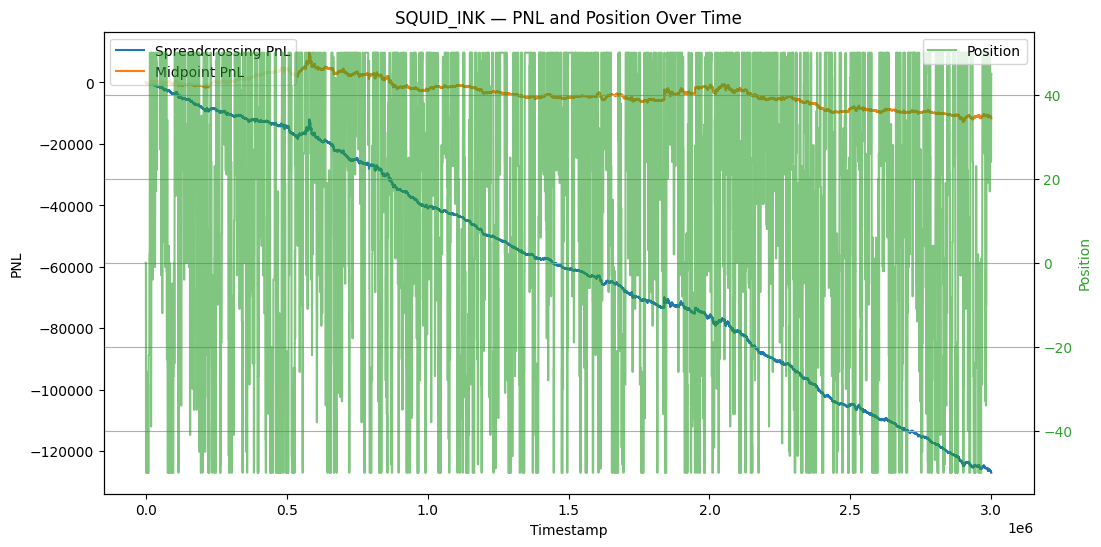

In [35]:
import matplotlib.pyplot as plt

product = SQUID_INK
metrics = bt.calculate_metrics(product)

print(f"Available metrics: {list(metrics.keys())}")

fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: PnL
ax1.plot(metrics['timestamp'], metrics['spreadcrossing_pnl'], label='Spreadcrossing PnL', color='tab:blue')
ax1.plot(metrics['timestamp'], metrics['midpoint_pnl'], label='Midpoint PnL', color='tab:orange')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("PNL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Second y-axis: Position
ax2 = ax1.twinx()
ax2.plot(metrics['timestamp'], metrics['position'], label='Position', color='tab:green', alpha=0.6)
ax2.set_ylabel("Position", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"{product} — PNL and Position Over Time")
plt.grid(True)
plt.show()


In [36]:
md = market_data_round_5_day_4.copy()

md[md['product'] == product]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,4,0,SQUID_INK,1929.0,1.0,1928.0,28.0,NaN,NaN,1931.0,2.0,1932.0,26.0,NaN,NaN,1930.0,0.0
18,4,100,SQUID_INK,1924.0,1.0,1923.0,25.0,NaN,NaN,1927.0,26.0,NaN,NaN,NaN,NaN,1925.5,0.0
38,4,200,SQUID_INK,1927.0,21.0,NaN,NaN,NaN,NaN,1930.0,21.0,NaN,NaN,NaN,NaN,1928.5,0.0
46,4,300,SQUID_INK,1926.0,27.0,NaN,NaN,NaN,NaN,1929.0,27.0,NaN,NaN,NaN,NaN,1927.5,0.0
66,4,400,SQUID_INK,1929.0,1.0,1927.0,28.0,NaN,NaN,1930.0,28.0,NaN,NaN,NaN,NaN,1929.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149925,4,999500,SQUID_INK,1905.0,22.0,NaN,NaN,NaN,NaN,1908.0,22.0,NaN,NaN,NaN,NaN,1906.5,0.0
149948,4,999600,SQUID_INK,1901.0,30.0,NaN,NaN,NaN,NaN,1903.0,3.0,1904.0,30.0,NaN,NaN,1902.0,0.0
149968,4,999700,SQUID_INK,1899.0,28.0,NaN,NaN,NaN,NaN,1902.0,29.0,NaN,NaN,NaN,NaN,1900.5,0.0
149976,4,999800,SQUID_INK,1899.0,34.0,NaN,NaN,NaN,NaN,1902.0,29.0,NaN,NaN,NaN,NaN,1900.5,0.0
